# Homework 2 - EECS 600 Deep Learning

Name: Roxanne Yang

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you are limited to basic operations within tensorflow and cannot use their high level APIs like tf.optimizer, tf.keras, etc.

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 10/15/19 - midnight EST

100 Points Total

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
tf.enable_eager_execution()

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (x_train.shape[0], 28*28))
x_test = np.reshape(x_test, (x_test.shape[0], 28*28))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255. 

## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.

Additionally, if you are having trouble getting autoencoders to fit with sigmoid hidden units, feel free to change them to ReLU units instead.

In [0]:
# Smaller dataset: 
"""
idx = np.random.randint(60000, size=1000)
x_train = x_train[idx]
y_train = y_train[idx]

idx = np.random.randint(10000, size=200)
x_test = x_test[idx]
y_test = y_test[idx]
"""

'\nidx = np.random.randint(60000, size=1000)\nx_train = x_train[idx]\ny_train = y_train[idx]\n\nidx = np.random.randint(10000, size=200)\nx_test = x_test[idx]\ny_test = y_test[idx]\n'

# Question 1
Implement an autoencoder that encodes MNIST images as a 64 dimensional representation. Your hidden layer should use sigmoid activation functions. Determine an appropriate learning rate and number of epochs to train your model. Use a minibatch size of 128.

In [0]:
# Adapted from Lecture 5 code
def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))

def accuracy(model, x, y, from_regular_NN=False):
  if (from_regular_NN):
    y_hat = model(x).numpy().argmax(axis=1)
  else:
    y_hat = model.classification_forward(x).numpy().argmax(axis=1)
  y_ = y.argmax(axis=1)
  acc = np.sum(y_hat==y_) / y.shape[0]
  return acc

class Model(object):
  def __init__(self, num_inputs, num_hidden=64, use_l1=False, alpha=0.01, use_sigmoid=False):
    # "Glorot" Uniform Initialization
    self.b1 = tf.Variable(tf.random.uniform(
                  (1, num_hidden),
                  minval=-np.sqrt(6/(1+num_hidden)),
                  maxval=np.sqrt(6/(1+num_hidden)),
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b1'))
    self.W1 = tf.Variable(tf.random.uniform(
                  (num_inputs, num_hidden),
                  minval=-np.sqrt(6/(num_inputs+num_hidden)),
                  maxval=np.sqrt(6/(num_inputs+num_hidden)),
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W1'))
    self.b2 = tf.Variable(tf.random.uniform(
                  (1, num_inputs),
                  minval=-np.sqrt(6/(1+num_hidden)),
                  maxval=np.sqrt(6/(1+num_hidden)),
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b2'))
    self.W2 = tf.Variable(tf.random.uniform(
                  (num_hidden, num_inputs),
                  minval=-np.sqrt(6/(num_inputs+num_hidden)),
                  maxval=np.sqrt(6/(num_inputs+num_hidden)),
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W2'))
    self.use_l1 = use_l1
    self.alpha = alpha
    self.use_sigmoid = use_sigmoid
  def __call__(self, x):
    return self.forward(x)
  
  def encode(self, x):
    # I ended up using relu for Q1 and 3 because sigmoid was really giving a bad fit. the input of anything has an output of image 3
    if (self.use_sigmoid):
      a1 = tf.nn.sigmoid(
          tf.linalg.matmul(x, self.W1) + self.b1
          )
    else:
      a1 = tf.nn.relu(
          tf.linalg.matmul(x, self.W1) + self.b1
          )
    return a1
  
  def decode(self, h):
    a2 = tf.nn.sigmoid(
          tf.linalg.matmul(h, self.W2) + self.b2
          )
    return a2

  def forward(self, x):
    a1 = self.encode(x)
    a2 = self.decode(a1)
    return a2
  
  def step(self, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
      current_loss = loss(self(inputs), outputs)
      if (self.use_l1):
        weight_reg = tf.norm(self.W1, ord=1, axis=[-2,-1])
        current_loss += self.alpha * weight_reg
    dW1, dW2, db1, db2 = t.gradient(current_loss, [self.W1, self.W2, self.b1, self.b2])
    
    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)

    if (self.use_l1):
      return weight_reg
  
  def init_classification(self, num_hidden=64, num_output=10):
    self.b3 = tf.Variable(tf.random.normal(
                  (1, num_output),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b2'))
    self.W3 = tf.Variable(tf.random.normal(
                  (num_hidden, num_output),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W2'))

  def classify(self, hidden_layer):
    output = tf.nn.softmax(
          tf.linalg.matmul(hidden_layer, self.W3) + self.b3
          )
    return output

  def classification_forward(self, x):
    hidden_layer = self.encode(x)
    output = self.classify(hidden_layer)
    return output;

def classification_learn(model, x, y, learning_rate):
    with tf.GradientTape() as t:
      current_loss = loss(model.classification_forward(x), y)

    dW3, db3 = t.gradient(current_loss, [model.W3, model.b3])
    
    model.W3.assign_sub(learning_rate * dW3)
    model.b3.assign_sub(learning_rate * db3)

In [0]:
model = Model(x_train.shape[1])

train_loss = []
test_loss = []

learning_rate = .1
batch_size = 128

for epoch in range(250):
  if (epoch % 50 == 0): print(epoch) # shows progress
  for start_idx in range(0, x_train.shape[0], batch_size):
    end_idx = start_idx + batch_size
    x_train_ = x_train[start_idx:end_idx, :]
    model.step(x_train_, x_train_, learning_rate)

  train_loss.append(loss(x_train, model(x_train)))
  test_loss.append(loss(x_test, model(x_test)))

0
50
100
150
200


Plot the training and testing reconstruction error for each epoch for your chosed number of epochs and learning rate using matplotlib.

In [0]:
# reconstruction error is just loss
def plot_loss(n, train_loss, test_loss):
  xxx = np.arange(0, n, 1)
  plt.plot(xxx, train_loss)
  plt.plot(xxx, test_loss)
  plt.legend(['Train', 'Test'])

  plt.xlabel("Epoch")
  plt.ylabel("Reconstruction Error")

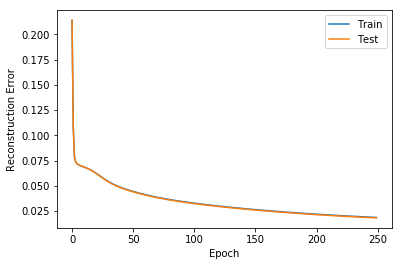

In [0]:
plot_loss(250, train_loss, test_loss)

Plot a 10x10 image of reconstructred random examples from your testing set.

the picture is supposed to be for: 1


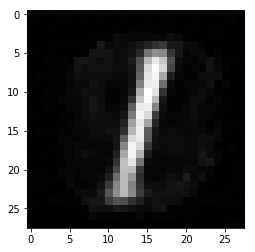

In [0]:
index = random.randint(0, 100)
print('the picture is supposed to be for:', y_test[index])
x_test_hat = model(x_test)
test_img = np.reshape(x_test_hat[index,:], (28, 28))
plt.imshow(test_img, cmap=plt.cm.gray)

How did you determine the appropriate learning rate and number of epochs for training?

I ended up using the same learning rate and epoch number as the lecture code. I experimented with increasing the learning rate to 0.2 and increasing the epoch numbers to 500 and 750, but they don't prove to be improving the loss by a lot. Additionally, when I modified the learning rate and epoch number for the sigmoid activation function, the output is still very far off.

## Question 1 Part 2
Add an $L_1$ regularization weight term to your loss function only on the weights to your encoder. Your new loss function should be $L(X) = \sum_i(X_i - decode(encode(X_i)))^2 + \alpha\sum_j|W_j|$ where $X$ is a minibatch of your data. Determine an appropriate value of $\alpha$. If you are having trouble getting started, consider values in powers of 10, i.e. $\alpha = 10^-5, 10^-4, 10^-3, ..., 10^1, 10^2, 10^3$.

In [0]:
model = Model(x_train.shape[1], use_l1=True, alpha=0.1)

train_loss = []
test_loss = []
weight_reg = []

learning_rate = .1
batch_size = 128

for epoch in range(250):
  if (epoch % 50 == 0): print(epoch) # shows progress
  w_r = 0
  for start_idx in range(0, x_train.shape[0], batch_size):
    end_idx = start_idx + batch_size
    x_train_ = x_train[start_idx:end_idx, :]
    w_r += model.step(x_train_, x_train_, learning_rate)

  train_loss.append(loss(x_train, model(x_train)))
  test_loss.append(loss(x_test, model(x_test)))
  weight_reg.append(w_r)

0
50
100
150
200


Plot the training and testing reconstruction error for each epoch for your chosed number of epochs and learning rate using matplotlib. Additionally, plot the weight regularization value at each epoch ($\sum_j|W_j|$).

In [0]:
def plot_reg_val(n, reg_val):
  xxx = np.arange(0, n, 1)
  plt.plot(xxx, reg_val)
  plt.legend(['Regularization Value'])

  plt.xlabel("Epoch")
  plt.ylabel("Regularization Value")

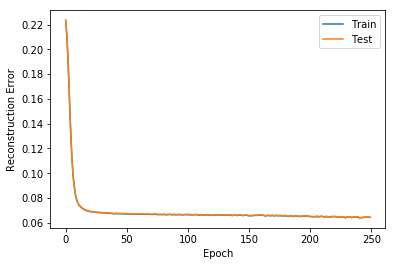

In [0]:
plot_loss(250, train_loss, test_loss)

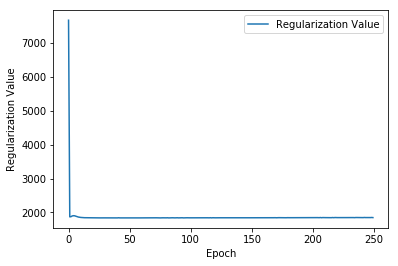

In [0]:
plot_reg_val(250, weight_reg)

How did you determine the appropriate weight regularization parameter?

As the prompt suggested, I tried powers of 10. I found that 0.1 gave a smooth curve (but looks different from the unregularized curve in part 1). I wanted the regularizor to be of some significance, but not dominate the loss function calculated. Therefore, I picked 0.1 as the alpha value.

##Question 2 Part 1
One of the [first papers](https://www.cs.toronto.edu/~hinton/science.pdf) in the deep learning literature proposed greedy layer wise training of deep neural networks. A greedy deep autoencoder first trains the first autoencoder, uses the representation to train the second autoencoder, etc. Train a greedy deep network for the MNIST data with the following layer sizes 400 - 200 - 50 - 10 - 2. Train on a random sample of 20000 MNIST rows. Use sigmoid activation layers and determine an appropriate learning rate.

In [0]:
def runLayer(layer, tot_epoch, x_train):
  learning_rate = .1
  batch_size = 128
  for epoch in range(tot_epoch):
    if (epoch % 50 == 0): print(epoch) # shows progress
    for start_idx in range(0, x_train.shape[0], batch_size):
      end_idx = start_idx + batch_size
      x_train_ = x_train[start_idx:end_idx, :]
      layer.step(x_train_, x_train_, learning_rate)
      
  return layer.encode(x_train)

In [0]:
tot_epoch = 100

# Layer size 400
layer_400 = Model(x_train.shape[1], 400, use_sigmoid=True)
output_400 = runLayer(layer_400, tot_epoch, x_train)

# Layer size 200
layer_200 = Model(400, 200, use_sigmoid=True)
output_200 = runLayer(layer_200, tot_epoch, output_400)

# Layer size 50
layer_50 = Model(200, 50, use_sigmoid=True)
output_50 = runLayer(layer_50, tot_epoch, output_200)

# Layer size 10
layer_10 = Model(50, 10, use_sigmoid=True)
output_10 = runLayer(layer_10, tot_epoch, output_50)

# Layer size 2
layer_2 = Model(10, 2, use_sigmoid=True)
output_2 = runLayer(layer_2, tot_epoch, output_10)

0
50
0
50
0
50
0
50
0
50


Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


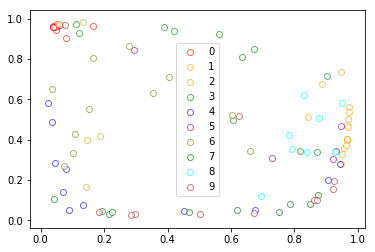

In [0]:
# Plot 100 data points
# Yihe Guo taught me how to use mask to solve this problem
def plot_scatter_pts(data):
  x = data[: 100, 0]
  y = data[: 100, 1]

  colors = ['red', 'orange', 'goldenrod', 'green', 'blue', 'purple',
          'olive', 'darkgreen', 'aqua', 'brown']

  for i in range(10):
    mask = np.array([x == i for x in y_train[: 100]])
    masked_data = tf.boolean_mask(data[:100], mask)
    x_post_mask = masked_data[:,0]
    y_post_mask = masked_data[:,1]
    plt.scatter(x_post_mask, y_post_mask, edgecolors = colors[i], c = 'white', label=str(i), alpha = 0.6)
    
  plt.legend()
  
plot_scatter_pts(output_2)

## Question 2 Part 2
Instead of training a multi-layer deep architecture, train just one layer of size 2. Once again use sigmoid activation functions and determine an appropriate learning rate.

In [0]:
layer_2_only = Model(x_train.shape[1], 2, use_sigmoid=True)
output_2_only = runLayer(layer_2_only, tot_epoch, x_train)

0
50


Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

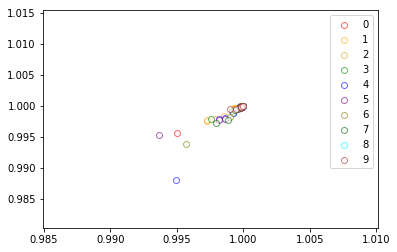

In [0]:
plot_scatter_pts(output_2_only)

## Question 2 Part 3
Train a standard feed-forward neural network with one hidden layer of size two and sigmoid activation functions for predicting which digit each of the training samples is from.

In [0]:
# turn y into categorical

num_classes = 10
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [0]:
# Need a new model - taken from HW1
class Model_Regular_NN(object):
  def __init__(self, num_hidden=2, num_output=10, num_inputs=784, use_relu=False):
    self.b1 = tf.Variable(tf.random.normal(
                  (1, num_hidden),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b1'))
    self.W1 = tf.Variable(tf.random.normal(
                  (num_inputs, num_hidden),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W1'))
    self.b2 = tf.Variable(tf.random.normal(
                  (1, num_output),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b2'))
    self.W2 = tf.Variable(tf.random.normal(
                  (num_hidden, num_output),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W2'))
    self.use_relu = use_relu
  def __call__(self, x):
    return self.forward(x)

  def get_hidden(self, x):
    a1 = tf.sigmoid(
          tf.linalg.matmul(x, self.W1) + self.b1
          )
    return a1;
  
  def forward(self, x):
    a1 = tf.sigmoid(
          tf.linalg.matmul(x, self.W1) + self.b1
          )
    a2 = tf.nn.sigmoid(
          tf.linalg.matmul(a1, self.W2) + self.b2
          )
    return a2
  
def train_step(model_nn, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model_nn(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model_nn.W1, model_nn.W2, model_nn.b1, model_nn.b2])
  
  model_nn.W1.assign_sub(learning_rate * dW1)
  model_nn.W2.assign_sub(learning_rate * dW2)
  model_nn.b1.assign_sub(learning_rate * db1)
  model_nn.b2.assign_sub(learning_rate * db2)

In [0]:
# Perform training
model_2_hidden_units = Model_Regular_NN()

train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []

for epoch in range(100):
  if (epoch % 50 == 0): print(epoch) # shows progress
  for start_idx in range(0, x_train.shape[0], batch_size):
    end_idx = start_idx + batch_size
    x_train_ = x_train[start_idx:end_idx, :]
    y_train_cat_ = y_train_cat[start_idx:end_idx, :]
    train_step(model_2_hidden_units, x_train_, y_train_cat_, learning_rate)
  train_loss.append(loss(y_train_cat, model_2_hidden_units(x_train)))
  test_loss.append(loss(y_test_cat, model_2_hidden_units(x_test)))
  train_accuracy.append(accuracy(model_2_hidden_units, x_train, y_train_cat, from_regular_NN=True))
  test_accuracy.append(accuracy(model_2_hidden_units, x_test, y_test_cat, from_regular_NN=True))

0
50
100
150
200


Pot the loss function and accuracy of your model

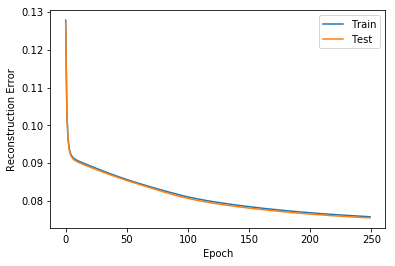

In [0]:
plot_loss(100, train_loss, test_loss)

In [0]:
# Plot accuracy
def plot_accr(n, train_loss, test_loss):
  xxx = np.arange(0, n, 1)
  plt.plot(xxx, train_loss)
  plt.plot(xxx, test_loss)
  plt.legend(['Train', 'Test'])

  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

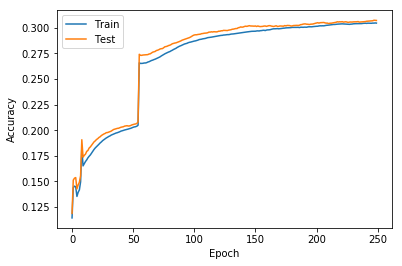

In [0]:
plot_accr(100, train_accuracy, test_accuracy)

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

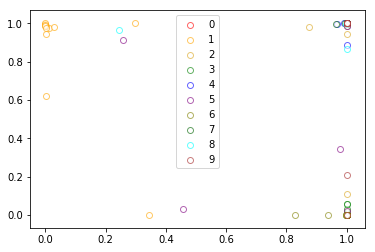

In [0]:
hidden_layer = model_2_hidden_units.get_hidden(x_train)

plot_scatter_pts(hidden_layer)

## Question 2 Part 4
How different are the representations that the different approaches learned? What might make them different?

The first representation is way more spread out than the second one, and it has a better distinction between each classification. This shows (at least in this example, with the same number of epochs and the same learning rate) that the greedy method of building more layers is way better than the one-step method. This could be because the greedy model actually trains the model 5 times as much as the one-step, since the greedy had 5 steps in total.

The third representation is also spread out, but it has way more 0 and 1 values than the first. This could be because the attempt to learn the classification straight-off encourages "extreme" hidden units.


# Question 3 Part 1
Build a denoising autoencoder for the MNIST data. On each batch, add random [normal gaussian noise](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html) to the inputs and then [clip the values](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html) such that they are between 0 and 1. Evaluate the following mean and standard deviation values for the noise.

| Mean  | Standard Deviation |
|-------|--------------------|
| (loc) | (scale)            |
| 0.0   | 0.05               |
| 0.1   | 0.05               |
| 0.0   | 0.2                |
| 0.1   | 0.2                |

Your evaluation should compare the reconstruction error on the testing data with no added error. Use sigmoid activation functions with 64 hidden units.

In [0]:
def runWithNoise(x_train, loc, scale):
  model = Model(x_train.shape[1])

  train_loss = []
  test_loss = []

  learning_rate = .1
  batch_size = 128

  for epoch in range(50):
    print(epoch) # shows progress
    for start_idx in range(0, x_train.shape[0], batch_size):
      end_idx = start_idx + batch_size
      x_train_ = x_train[start_idx:end_idx, :]
      gaussian_noise = np.random.normal(loc, scale, x_train_.shape)
      x_train_ = np.clip(x_train_ + gaussian_noise, 0, 1).astype('float32')
      model.step(x_train_, x_train_, learning_rate)

    train_loss.append(loss(x_train, model(x_train)))
    test_loss.append(loss(x_test, model(x_test)))
    
  return train_loss, test_loss, model

In [45]:
# Run with error 4 times
train_loss_0, test_loss_0, model_0 = runWithNoise(x_train, 0.0, 0.05)
train_loss_1, test_loss_1, model_1 = runWithNoise(x_train, 0.1, 0.05)
train_loss_2, test_loss_2, model_2 = runWithNoise(x_train, 0.0, 0.2)
train_loss_3, test_loss_3, model_3 = runWithNoise(x_train, 0.1, 0.2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [0]:
# Plot with comparison to original
def plot_loss_wrt_orig(n, loss, loss_0, loss_1, loss_2, loss_3, name):
  xxx = np.arange(0, n, 1)
  plt.plot(xxx, train_loss[0:50])
  plt.plot(xxx, train_loss_0)
  plt.plot(xxx, train_loss_1)
  plt.plot(xxx, train_loss_2)
  plt.plot(xxx, train_loss_3)
  plt.legend(['Original', 'Mean=0, Std=0.05', 'Mean=0.1, Std=0.05', 'Mean=0, Std=0.2', 'Mean=0.1, Std=0.2'])

  plt.xlabel("Epoch")
  plt.ylabel(name)

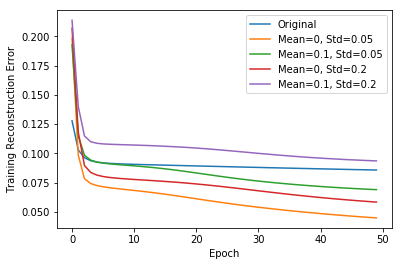

In [58]:
plot_loss_wrt_orig(50, train_loss, train_loss_0, train_loss_1, train_loss_2, train_loss_3, "Training Reconstruction Error")

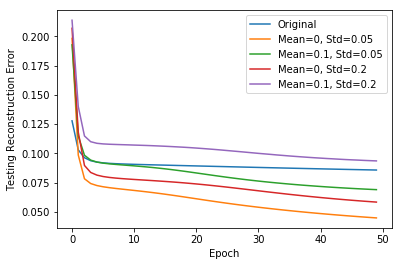

In [59]:
plot_loss_wrt_orig(50, test_loss, test_loss_0, test_loss_1, test_loss_2, test_loss_3, "Testing Reconstruction Error")

## Question 3 Part 2
Choose one of the denoising autoncoders from the previous step. Use the hidden representation to train a model to predict the number present in the image.

In [61]:
# Train classification in autoencoder. Uses model_0
batch_size = 128
learning_rate = 0.1

train_acc = []
test_acc = []

model_0.init_classification()

for epoch in range(250):
  if (epoch % 50 == 0): print(epoch) # shows progress

  for start_idx in range(0, x_train.shape[0], batch_size):
    end_idx = start_idx + batch_size
    x_train_ = x_train[start_idx:end_idx, :]
    y_train_cat_ = y_train_cat[start_idx:end_idx]
    classification_learn(model_0, x_train_, y_train_cat_, learning_rate)
      
  y_hat = model_0.classification_forward(x_train).numpy().argmax(axis=1)
  y_ = y_train_cat.argmax(axis=1)
  z = np.sum(y_hat==y_)
  train_acc.append(accuracy(model_0, x_train, y_train_cat))
  test_acc.append(accuracy(model_0, x_test, y_test_cat))


0
50
100
150
200


Plot the training and testing accuracy for each epoch during training.

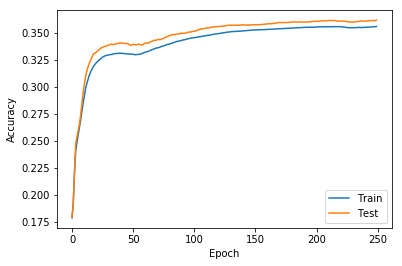

In [62]:
plot_accr(250, train_acc, test_acc)